In [1]:
%cd /content/drive/MyDrive/KTH/course/gpu/hw4

/content/drive/MyDrive/KTH/course/gpu/hw4


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-utm2hi4t
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-utm2hi4t
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=d226001601da62a53a92e2565bcb3952c7c17d596e80796c80cf378c496d00ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-yl88_hlk/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [4]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/hw4/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/hw4/result.out


In [ ]:
%%cuda --name lab4_ex2.cu 

#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len, int offset) {
  //@@ Insert code to implement vector addition here
  // Get our global thread ID
  const int idx = blockIdx.x*blockDim.x+threadIdx.x+offset;
  // Make sure we do not go out of bounds
  if (idx < len)
      out[idx] = in1[idx] + in2[idx];
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  //printf("%f", startt->tv_usec*1.0e-6);
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}


int main(int argc, char **argv) {
  
  int inputLength;
  DataType *hostInput1;
  DataType *hostInput2;
  DataType *hostOutput;
  DataType *resultRef;
  DataType *deviceInput1;
  DataType *deviceInput2;
  DataType *deviceOutput;
  int nStreams; //nStreams=S_seg

  //@@ Insert code below to read in inputLength from args
  sscanf(argv[1],"%d",&inputLength);
  sscanf(argv[2],"%d",&nStreams);

  printf("The input length is %d\n", inputLength);
  printf("Number of segment is %d\n", nStreams);

  //@@ Insert code below to allocate Host memory for input and output
  hostInput1 = (DataType *)malloc(inputLength*sizeof(DataType));
  hostInput2 = (DataType *)malloc(inputLength*sizeof(DataType));
  hostOutput = (DataType *)malloc(inputLength*sizeof(DataType));
  resultRef = (DataType *)malloc(inputLength*sizeof(DataType));

  //@@ Insert code below to initialize hostInput1 and hostInput2 to random numbers, and create reference result in CPU
  for (int i = 0; i < inputLength; i++)
  {
    hostInput1[i] = (double) rand() / RAND_MAX;
    hostInput2[i] = (double) rand() / RAND_MAX;
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceInput1, inputLength*sizeof(DataType));
  cudaMalloc(&deviceInput2, inputLength*sizeof(DataType));
  cudaMalloc(&deviceOutput, inputLength*sizeof(DataType));

  //@@ Insert code to below to Copy memory to the GPU here
  struct timeval timeh2d;
  timeStart(&timeh2d);
  const int streamSize = (int)ceil((float)inputLength/nStreams);;
  const int streamBytes = streamSize*sizeof(DataType);
  cudaStream_t stream[nStreams];
  for (int i = 0; i < nStreams; i++)
      cudaStreamCreate(&stream[i]); 
  for (int i=0; i<nStreams; i++)
  {
      int offset = i*streamSize;
      cudaMemcpyAsync(&deviceInput1[offset], &hostInput1[offset], streamBytes, cudaMemcpyHostToDevice, stream[i]);
      cudaMemcpyAsync(&deviceInput2[offset], &hostInput2[offset], streamBytes, cudaMemcpyHostToDevice, stream[i]);
  }
  //cudaMemcpy(deviceInput1, hostInput1, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  //cudaMemcpy(deviceInput2, hostInput2, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  printf("H2D: ");
  timeStop(&timeh2d);

  //@@ Initialize the 1D grid and block dimensions here
  int blockSize;
  blockSize = 1024; // set this value
  //gridSize = (int)ceil((float)inputLength/blockSize);

  //@@ Launch the GPU Kernel here
  struct timeval timekernel;
  timeStart(&timekernel);
  for (int i=0; i<nStreams; i++)
  {
      int offset = i*streamSize;
      vecAdd<<<streamSize, blockSize, 0, stream[i]>>>(deviceInput1, deviceInput2, deviceOutput, inputLength, offset);
  }
  //vecAdd<<<gridSize, blockSize>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
  //cudaStreamSynchronize();
  printf("Kernel: ");
  timeStop(&timekernel);

  //@@ Copy the GPU memory back to the CPU here
  struct timeval timed2h;
  timeStart(&timed2h);
  //cudaMemcpy( hostOutput, deviceOutput, inputLength*sizeof(DataType), cudaMemcpyDeviceToHost );
  for (int i=0; i<nStreams; i++)
  {
      int offset = i*streamSize;
      cudaMemcpyAsync(&hostOutput[offset], &deviceOutput[offset], inputLength*sizeof(DataType), cudaMemcpyDeviceToHost);
  }
  printf("D2H: ");
  timeStop(&timed2h);

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < inputLength; i++)
  {
    //printf("resultRef[i]= %.3f", resultRef[i]);
    //printf("hostOutput[i]= %.3f", hostOutput[i]);
    if (resultRef[i] != hostOutput[i])
      printf("resultRef[i]= %.3f, hostOutput[i]= %.3f", resultRef[i], hostOutput[i]);
  }

  //Destroy stream
  for (int i = 0; i < nStreams; i++)
    cudaStreamDestroy(stream[i]); 

  //@@ Free the GPU memory here
  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  //@@ Free the CPU memory here
  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  printf("===========================================\n");
  return 0;
}



'File written in /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2.cu'

In [5]:
%%cuda --name lab4_ex2_v2.cu 

#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len, int offset) {
  //@@ Insert code to implement vector addition here
  // Get our global thread ID
  const int idx = blockIdx.x*blockDim.x+threadIdx.x+offset;
  // Make sure we do not go out of bounds
  if (idx < len)
      out[idx] = in1[idx] + in2[idx];
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  //printf("%f", startt->tv_usec*1.0e-6);
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}


int main(int argc, char **argv) {
  
  int inputLength;
  DataType *hostInput1;
  DataType *hostInput2;
  DataType *hostOutput;
  DataType *resultRef;
  DataType *deviceInput1;
  DataType *deviceInput2;
  DataType *deviceOutput;
  int nStreams; //nStreams=S_seg

  //@@ Insert code below to read in inputLength from args
  sscanf(argv[1],"%d",&inputLength);
  sscanf(argv[2],"%d",&nStreams);

  printf("The input length is %d\n", inputLength);
  printf("Number of segment is %d\n", nStreams);

  const int streamSize = (int)ceil((float)inputLength/nStreams);;
  const int streamBytes = streamSize*sizeof(DataType);

  //@@ Insert code below to allocate Host memory for input and output
  hostInput1 = (DataType *)malloc(nStreams*streamBytes);
  hostInput2 = (DataType *)malloc(nStreams*streamBytes);
  hostOutput = (DataType *)malloc(nStreams*streamBytes);
  resultRef = (DataType *)malloc(nStreams*streamBytes);

  //@@ Insert code below to initialize hostInput1 and hostInput2 to random numbers, and create reference result in CPU
  for (int i = 0; i < inputLength; i++)
  {
    hostInput1[i] = (double) rand() / RAND_MAX;
    hostInput2[i] = (double) rand() / RAND_MAX;
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceInput1, nStreams*streamBytes);
  cudaMalloc(&deviceInput2, nStreams*streamBytes);
  cudaMalloc(&deviceOutput, nStreams*streamBytes);

  //@@ Initialize the 1D grid and block dimensions here
  int blockSize;
  blockSize = 1024; // set this value
  //gridSize = (int)ceil((float)inputLength/blockSize);

  //@@ Insert code to below to Copy memory to the GPU here
  struct timeval timeh2d;
  timeStart(&timeh2d);
  cudaStream_t stream[nStreams];
  for (int i = 0; i < nStreams; i++)
      cudaStreamCreate(&stream[i]); 
  for (int i=0; i<nStreams; i++)
  {
      int offset = i*streamSize;
      cudaMemcpyAsync(&deviceInput1[offset], &hostInput1[offset], streamBytes, cudaMemcpyHostToDevice, stream[i]);
      cudaMemcpyAsync(&deviceInput2[offset], &hostInput2[offset], streamBytes, cudaMemcpyHostToDevice, stream[i]);
      vecAdd<<<streamSize, blockSize, 0, stream[i]>>>(deviceInput1, deviceInput2, deviceOutput, inputLength, offset);
      cudaMemcpyAsync(&hostOutput[offset], &deviceOutput[offset], streamBytes, cudaMemcpyDeviceToHost, stream[i]);
  }
  //cudaMemcpy(deviceInput1, hostInput1, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  //cudaMemcpy(deviceInput2, hostInput2, inputLength*sizeof(DataType), cudaMemcpyHostToDevice);
  printf("Whole: ");
  timeStop(&timeh2d);


  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < inputLength; i++)
  {
    //printf("resultRef[i]= %.3f", resultRef[i]);
    //printf("hostOutput[i]= %.3f", hostOutput[i]);
    if (resultRef[i] != hostOutput[i])
      printf("resultRef[%d]= %.3f, hostOutput[%d]= %.3f", i, resultRef[i], i, hostOutput[i]);
  }

  //Destroy stream
  for (int i = 0; i < nStreams; i++)
    cudaStreamDestroy(stream[i]); 

  //@@ Free the GPU memory here
  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  //@@ Free the CPU memory here
  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  printf("===========================================\n");
  return 0;
}



'File written in /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2.cu'

In [ ]:
!nvcc --default-stream per-thread -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2.cu 

In [6]:
!nvcc --default-stream per-thread -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2 /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2.cu 

In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 1024 4

The input length is 1024
Number of segment is 4
H2D: Time: 0.000057 (s)
Kernel: Time: 0.000045 (s)
D2H: Time: 0.000055 (s)


In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 131070 4

The input length is 131070
Number of segment is 4
H2D: Time: 0.000519 (s)
Kernel: Time: 0.001785 (s)
D2H: Time: 0.000855 (s)


In [25]:
%%shell 
#!/bin/bash
for VARIABLE in 4 8 16 32 64 
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2 262144 $VARIABLE
done  

The input length is 262144
Number of segment is 4
Whole: Time: 0.006725 (s)
The input length is 262144
Number of segment is 8
Whole: Time: 0.006392 (s)
The input length is 262144
Number of segment is 16
Whole: Time: 0.006744 (s)
The input length is 262144
Number of segment is 32
Whole: Time: 0.007961 (s)
The input length is 262144
Number of segment is 64
Whole: Time: 0.008877 (s)


CalledProcessError: ignored

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 128 256 1024 4096 16384 65536 131070 262144 1048576
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2 $VARIABLE 8
done  

The input length is 128
Number of segment is 8
Whole: Time: 0.000201 (s)
The input length is 256
Number of segment is 8
Whole: Time: 0.000275 (s)
The input length is 1024
Number of segment is 8
Whole: Time: 0.000277 (s)
The input length is 4096
Number of segment is 8
Whole: Time: 0.000323 (s)
The input length is 16384
Number of segment is 8
Whole: Time: 0.000673 (s)
The input length is 65536
Number of segment is 8
Whole: Time: 0.001967 (s)
The input length is 131070
Number of segment is 8
Whole: Time: 0.003556 (s)
The input length is 262144
Number of segment is 8
Whole: Time: 0.006408 (s)
The input length is 1048576
Number of segment is 8
Whole: Time: 0.024686 (s)


CalledProcessError: ignored

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 128 256 1024 4096 16384 65536 131070 262144 1048576
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 $VARIABLE 16
done  

The input length is 128
Number of segment is 16
H2D: Time: 0.000945 (s)
Kernel: Time: 0.000081 (s)
D2H: Time: 0.000049 (s)
The input length is 256
Number of segment is 16
H2D: Time: 0.000256 (s)
Kernel: Time: 0.000075 (s)
D2H: Time: 0.000030 (s)
The input length is 1024
Number of segment is 16
H2D: Time: 0.000212 (s)
Kernel: Time: 0.000072 (s)
D2H: Time: 0.000034 (s)
The input length is 4096
Number of segment is 16
H2D: Time: 0.000258 (s)
Kernel: Time: 0.000094 (s)
D2H: Time: 0.000051 (s)
The input length is 16384
Number of segment is 16
H2D: Time: 0.000395 (s)
Kernel: Time: 0.000263 (s)
D2H: Time: 0.000172 (s)
The input length is 65536
Number of segment is 16
H2D: Time: 0.000529 (s)
Kernel: Time: 0.000963 (s)
D2H: Time: 0.000415 (s)
The input length is 131070
Number of segment is 16
H2D: Time: 0.000867 (s)
Kernel: Time: 0.001826 (s)
D2H: Time: 0.000743 (s)
resultRef[i]= 1.762, hostOutput[i]= 0.000resultRef[i]= 1.803, hostOutput[i]= 0.000resultRef[i]= 1.088, hostOutput[i]= 0.000resultR

CalledProcessError: ignored

Text(0, 0.5, 'Time (s)')

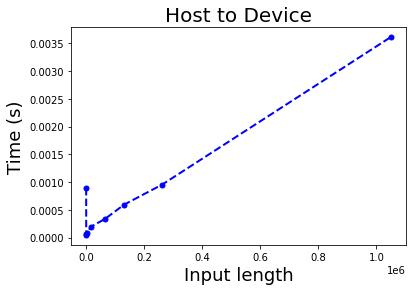

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131070, 262144, 1048576],[0.000893, 0.000049, 0.000072, 0.000089, 0.000195, 0.000339, 0.000595, 0.000956, 0.003608], 'bo--', linewidth=2, markersize=5)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

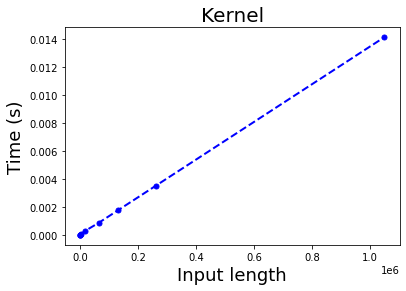

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131070, 262144, 1048576],[0.000044, 0.000035, 0.000047, 0.000087, 0.000301, 0.000908, 0.001792, 0.003557, 0.014159], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

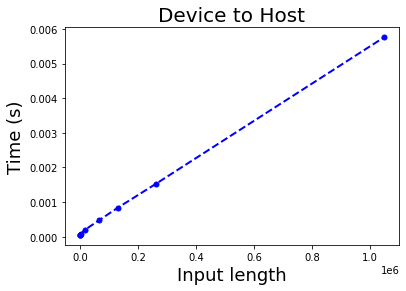

In [ ]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131072, 262144, 1048576],[0.000052, 0.000062, 0.000059, 0.000083, 0.000191, 0.000469, 0.000838, 0.001527, 0.005763], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

In [32]:
!nvprof -f --output-profile /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2_4.nvprof /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2 262144 4

The input length is 262144
Number of segment is 4
==15326== NVPROF is profiling process 15326, command: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2 262144 4
Whole: Time: 0.008945 (s)
==15326== Generated result file: /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2_v2_4.nvprof


different length performance

Text(0, 0.5, 'Time (s)')

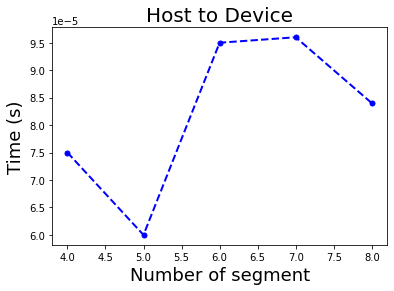

In [ ]:
import matplotlib.pyplot as plt

plt.plot([4, 5, 6, 7, 8],[0.000075, 0.000060, 0.000095, 0.000096, 0.000084], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Number of segment', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

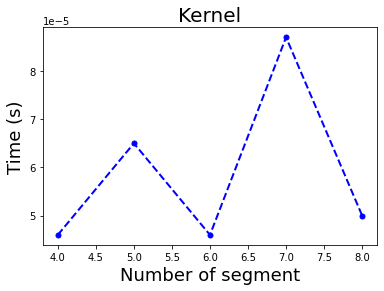

In [ ]:
import matplotlib.pyplot as plt

plt.plot([4, 5, 6, 7, 8],[0.000046, 0.000065, 0.000046, 0.000087, 0.000050], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Number of segment', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

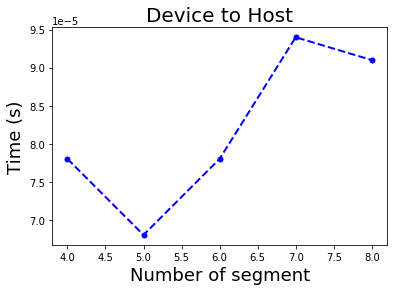

In [ ]:
import matplotlib.pyplot as plt

plt.plot([4, 5, 6, 7, 8],[0.000078, 0.000068, 0.000078, 0.000094, 0.000091], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Number of segment', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

In [ ]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2.cu 

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 128 256 1024 4096 16384 65536 131072 262144 1048576
do
    ! /content/drive/MyDrive/KTH/course/gpu/hw4/src/lab4_ex2 $VARIABLE 16
done 

The input length is 128
Number of segment is 16
H2D: Time: 0.000230 (s)
Kernel: Time: 0.000071 (s)
D2H: Time: 0.000033 (s)
The input length is 256
Number of segment is 16
H2D: Time: 0.000198 (s)
Kernel: Time: 0.000064 (s)
D2H: Time: 0.000028 (s)
The input length is 1024
Number of segment is 16
H2D: Time: 0.000196 (s)
Kernel: Time: 0.000069 (s)
D2H: Time: 0.000034 (s)
The input length is 4096
Number of segment is 16
H2D: Time: 0.000227 (s)
Kernel: Time: 0.000076 (s)
D2H: Time: 0.000054 (s)
The input length is 16384
Number of segment is 16
H2D: Time: 0.000275 (s)
Kernel: Time: 0.000124 (s)
D2H: Time: 0.000130 (s)
The input length is 65536
Number of segment is 16
H2D: Time: 0.000578 (s)
Kernel: Time: 0.000090 (s)
D2H: Time: 0.000385 (s)
The input length is 131072
Number of segment is 16
H2D: Time: 0.000983 (s)
Kernel: Time: 0.000080 (s)
D2H: Time: 0.000805 (s)
The input length is 262144
Number of segment is 16
H2D: Time: 0.001154 (s)
Kernel: Time: 0.000088 (s)
D2H: Time: 0.001501 (s)
The 

CalledProcessError: ignored

Text(0, 0.5, 'Time (s)')

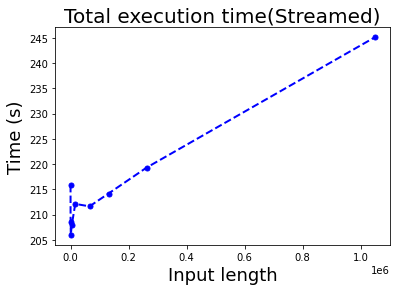

In [5]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131072, 262144, 1048576],[215.84957, 208.48712, 205.95383, 207.82774, 212.10295, 211.6157, 214.16284, 219.29787, 245.13448], 'bo--', linewidth=2, markersize=5)
plt.title('Total execution time(Streamed)', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

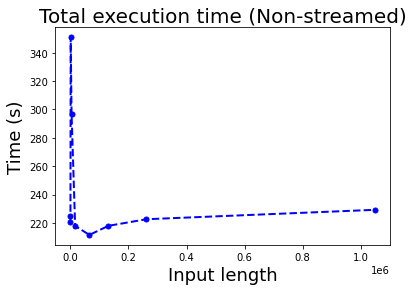

In [4]:
import matplotlib.pyplot as plt

plt.plot([128, 256, 1024, 4096, 16384, 65536, 131072, 262144, 1048576],[220.31515, 224.89046, 350.97177, 296.93606, 217.83114, 211.47932, 217.89678, 222.55117, 229.19124], 'bo--', linewidth=2, markersize=5)
plt.title('Total execution time (Non-streamed)', fontsize=20)
plt.xlabel('Input length', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

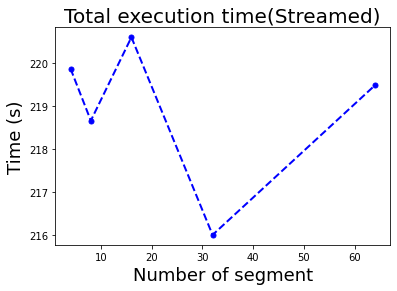

In [7]:
import matplotlib.pyplot as plt

plt.plot([4, 8, 16, 32, 64],[219.87174, 218.66212, 220.60347, 216.00315, 219.48416], 'bo--', linewidth=2, markersize=5)
plt.title('Total execution time(Streamed)', fontsize=20)
plt.xlabel('Number of segment', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)